In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from data.id_dataloader import load_cifar10, load_intel_image, load_mnist, load_cifar100
from data.ood_dataloader import load_ood_data, load_ood_svhn, load_ood_intel_image, load_ood_fashion_mnist, load_ood_kmnist
from data.classes import cifar10_classes, mnist_classes, intel_image_classes, cifar100_classes
from data.adversarial_data import add_random_noise, rotate_images

from models.models import resnet50, wideresnet2810, vgg16, inceptionv3, efficientnetb2
from models.pretrained_models import pretrained_resnet50, pretrained_vgg16

from rsnn_functions.rsnn_loss import BinaryCrossEntropy
from rsnn_functions.belief_mass_betp import belief_to_mass, final_betp

from utils.eval_utils import load_model, load_all_predictions
from utils.train_utils import train_val_split

from metrics.uncertainty_metrics import entropy, compute_vertices, credal_set_width, specificity_metric
from metrics.ood_metrics import evaluate_metrics
from metrics.calibration_metrics import expected_calibration_error, calculate_and_print_ece
from metrics.classification_metrics import compute_confidence_scores, compute_correct_incorrect_indices

2024-11-18 00:57:01.338669: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 00:57:01.338741: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 00:57:01.338787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 00:57:01.349117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 00:57:03.723650: I tensorflow/core/comm

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    num_gpus = len(gpus)
    print(f"Number of GPUs available: {num_gpus}")
    # Set GPUs to use. For example, limit TensorFlow to use 3 GPUs
    tf.config.experimental.set_visible_devices(gpus[:3], 'GPU')
    
# Create a MirroredStrategy for multi-GPU use
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of GPUs available: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [4]:
# Define configurations
selected_dataset = "cifar10"  # Choose the dataset
selected_model = "resnet50"   # Choose the model
ood_dataset_1 = "ood_svhn" # Choose OoD datasets
ood_dataset_2 = "ood_intel_image"

In [5]:
num_classes = {"cifar10": 10, "mnist": 10, "intel_image": 6, "cifar100": 100, "svhn": 10, "fmnist": 10, "kmnist":10}

dataset_loader = {
 "cifar10": load_cifar10, 
 "mnist": load_mnist, 
 "intel_image": load_intel_image, 
 "cifar100": load_cifar100, 
 "ood_svhn": load_ood_svhn, 
 "ood_intel_image": load_ood_intel_image,
 "ood_fashion_mnist": load_ood_fashion_mnist, 
 "ood_kmnist":load_ood_kmnist
}

models = {
    "resnet50": resnet50, 
    "wideresnet_28_10": wideresnet2810, 
    "vgg16": vgg16,
    "inception_v3": inceptionv3,
    "efficientnet_b2": efficientnetb2
}

pretrained_models = {
    "pretrained_resnet50": pretrained_resnet50, 
    "pretrained_vgg16": pretrained_vgg16,
}

class_list_functions = {
    "cifar10": cifar10_classes,
     "mnist": mnist_classes, 
    "intel_image": intel_image_classes, 
    "cifar100": cifar100_classes, 
}

In [6]:
# Class list
classes = class_list_functions[selected_dataset]()
print("Classes:", classes)

# Load dataset based on selected_dataset
x_train, y_train, x_test_org, x_test, y_test = dataset_loader[selected_dataset]()

# Infer input_shape based on selected_dataset
input_shape = x_train.shape[1:]

# One-hot encoding of test labels
y_test_one_hot = tf.one_hot(y_test, num_classes[selected_dataset])

# Train-validation split
x_train, y_train, y_train_one_hot, x_val, y_val, y_val_one_hot = train_val_split(x_train, y_train, num_classes[selected_dataset], val_samples=-10000)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
""" 
Load saved CNN model
"""
# Multi-GPU run
with strategy.scope():      
    # Create the model based on selected_model
    if selected_model in pretrained_models:
        model = pretrained_models[selected_model](input_shape=input_shape, num_classes=num_classes[selected_dataset], final_activation='softmax')
    else:
        model = models[selected_model](input_shape=input_shape, num_classes=num_classes[selected_dataset], final_activation='softmax')
    
    # Compile the model 
    model.compile(loss='categorical_crossentropy',
                optimizer="adam",
                metrics=['accuracy'])

model = load_model(selected_model, selected_dataset, model_type = "CNN")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [8]:
""" 
Load saved RS-NN model
"""
new_classes = np.load('new_classes.npy', allow_pickle=True)

# Multi-GPU run
with strategy.scope():      
    # Create the model based on selected_model
    if selected_model in pretrained_models:
        new_model = pretrained_models[selected_model](input_shape=input_shape,  num_classes=len(new_classes), final_activation='sigmoid')
    else:
        new_model = models[selected_model](input_shape=input_shape, num_classes=len(new_classes), final_activation='sigmoid')

new_model = load_model(selected_model, selected_dataset, model_type = "RSNN")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              2098

## Test Accuracy of RS-NN and CNN

In [9]:
# Get predictions and calculate accuracy of RS-NN
new_classes_with_full = list(new_classes) + [set(classes)]
new_classes_with_full, len(new_classes_with_full)

test_preds = new_model.predict(x_test, verbose=1)
test_preds_mass = belief_to_mass(test_preds, list(new_classes))
final_bet_p = final_betp(test_preds_mass, classes, new_classes_with_full)

final_bet_p_indices = np.argmax(final_bet_p, axis = -1)
accuracy = (np.sum(final_bet_p_indices == y_test)/len(y_test))*100
print(f"Test Accuracy of RS-NN using pignistic probability: {accuracy}%")

2024-11-18 00:57:14.323028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-11-18 00:57:14.488532: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-11-18 00:57:14.491837: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-11-18 00:57:14.491894: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-11-18 00:57:14.492099: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  9/313 [..............................] - ETA: 4s

2024-11-18 00:57:14.950122: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-11-18 00:57:14.953502: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-11-18 00:57:15.000091: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-11-18 00:57:15.003267: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


313/313 [==============================] - 7s 17ms/step
Test Accuracy of RS-NN using pignistic probability: 92.99%


In [10]:
# Get predictions and calculate accuracy of CNN
y_pred = model.predict(x_test)
score = model.evaluate(x_test, y_test_one_hot)
print(f"Test Accuracy of standard CNN for test images: {score[1]*100}%")

313/313 [==============================] - 6s 18ms/step - loss: 0.4829 - accuracy: 0.9025
Test Accuracy of standard CNN for test images: 90.24999737739563%


## Sample predictions by RS-NN

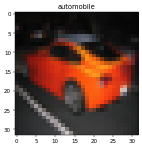

{'ship', 'automobile'}			1.0
{'automobile'}			1.0
{'cat', 'automobile'}			1.0
{'frog', 'automobile', 'deer'}			1.0
{'automobile', 'deer'}			1.0

-------------Mass Values----------------------------
{'automobile'}			1.0
{'cat', 'truck'}			4.1934939510879414e-19
{'frog', 'ship'}			7.047596638400129e-20
{'truck'}			1.4518765594152198e-21
{'cat', 'frog'}			6.626125836254366e-22

-------------Pignistic Probabilities----------------------------
automobile			1.0
truck			2.1112657411381229e-19
cat			2.1001828024614727e-19
frog			3.581786241703593e-20
ship			3.5294117290771384e-20

-------------Entropy----------------------------
	1.3117046911301238e-17





In [11]:
number_of_samples = 1

for im_index in np.random.randint(0, len(test_preds), number_of_samples):
  plt.figure(figsize=(4,4), dpi=40)
  im = x_test_org[im_index]
  plt.imshow(im, cmap="gray")
  plt.title(str(classes[y_test[im_index]]))
  plt.show()
  top_labels = np.argsort(test_preds[im_index])[::-1][:5]
  for t in top_labels:
    print(f"{new_classes[t]}\t\t\t{test_preds[im_index][t]}")
  
  print("\n-------------Mass Values----------------------------")
  top_labels_mass = np.argsort(test_preds_mass[im_index])[::-1][:5]
  for t in top_labels_mass:
    print(f"{new_classes_with_full[t]}\t\t\t{test_preds_mass[im_index][t]}")
  
  print("\n-------------Pignistic Probabilities----------------------------")
  top_labels_pignistic = np.argsort(final_bet_p[im_index])[::-1][:5]
  for t in top_labels_pignistic:
    print(f"{classes[t]}\t\t\t{final_bet_p[im_index][t]}")
      
  print("\n-------------Entropy----------------------------")
  print(f"\t{entropy(final_bet_p)[im_index]}")

  print("\n\n")

## Out-of-distribution(OoD) detection

In [12]:
# Load OoD datasets corresponding to selected dataset
test_preds = {}
final_bet_ps = {}
y_preds = {}
test_preds_masses = {}
ood_datasets = load_ood_data(selected_dataset, dataset_loader)
ood_dataset_names = [ood_dataset_1, ood_dataset_2]

for ood_dataset_name in ood_dataset_names:
    x_test_ood = ood_datasets[ood_dataset_name]['x_test']
    test_preds[ood_dataset_name] = new_model.predict(x_test_ood, verbose=1)
    test_preds_masses[ood_dataset_name] = belief_to_mass(test_preds[ood_dataset_name], list(new_classes))
    final_bet_ps[ood_dataset_name] = final_betp(test_preds_masses[ood_dataset_name], classes, new_classes_with_full)
    y_preds[ood_dataset_name] = model.predict(x_test_ood)

# RS-NN predictions on OoD datasets   
final_bet_p_1 = final_bet_ps[ood_dataset_1]
final_bet_p_2 = final_bet_ps[ood_dataset_2]

# CNN predictions on OoD datasets   
y_pred_1 = y_preds[ood_dataset_1]
y_pred_2 = y_preds[ood_dataset_2]

# Baseline (LB-BNN, ENN) predictions on OoD datasets   
lbbnn_preds_id, lbbnn_preds_1, lbbnn_preds_2, enn_preds_id, enn_preds_1, enn_preds_2 = load_all_predictions(selected_dataset)

94/94 [==============================] - 2s 16ms/step


In [13]:
predictions_dict = {
    "RS-NN": {selected_dataset: final_bet_p, "ood_dataset_1": final_bet_p_1, "ood_dataset_2": final_bet_p_2},
    "LB-BNN": {selected_dataset: lbbnn_preds_id, "ood_dataset_1": lbbnn_preds_1, "ood_dataset_2": lbbnn_preds_2},
    "ENN": {selected_dataset: enn_preds_id, "ood_dataset_1": enn_preds_1, "ood_dataset_2": enn_preds_2},
    "CNN": {selected_dataset: y_pred, "ood_dataset_1": y_pred_1, "ood_dataset_2": y_pred_2}
}

In [14]:
baselines = ["RS-NN", "LB-BNN", "ENN", "CNN"]
ood_dataset_strings = ["ood_dataset_1", "ood_dataset_2"]

for baseline in baselines:
    for ood_dataset in ood_dataset_strings:
        # Calculate AUROC and AUPRC
        metrics_data = evaluate_metrics(baseline, ood_dataset, entropy(predictions_dict[baseline][selected_dataset]), entropy(predictions_dict[baseline][ood_dataset]))
        
for index, (dataset_name, baselines) in enumerate(metrics_data.items()):
    name = ood_dataset_names[index]
    print(f"------------{dataset_name} ({name})------------")
    for model_name, metrics in baselines.items():
        print(f"{model_name} - AUROC: {metrics['AUROC']:.6f}\tAUPRC: {metrics['AUPRC']:.6f}")


------------ood_dataset_1 (ood_svhn)------------
RS-NN - AUROC: 0.939202	AUPRC: 0.929571
LB-BNN - AUROC: 0.881394	AUPRC: 0.819594
ENN - AUROC: 0.927636	AUPRC: 0.890482
CNN - AUROC: 0.931056	AUPRC: 0.909975
------------ood_dataset_2 (ood_intel_image)------------
RS-NN - AUROC: 0.995496	AUPRC: 0.940945
LB-BNN - AUROC: 0.822053	AUPRC: 0.551689
ENN - AUROC: 0.856737	AUPRC: 0.580896
CNN - AUROC: 0.900016	AUPRC: 0.538807


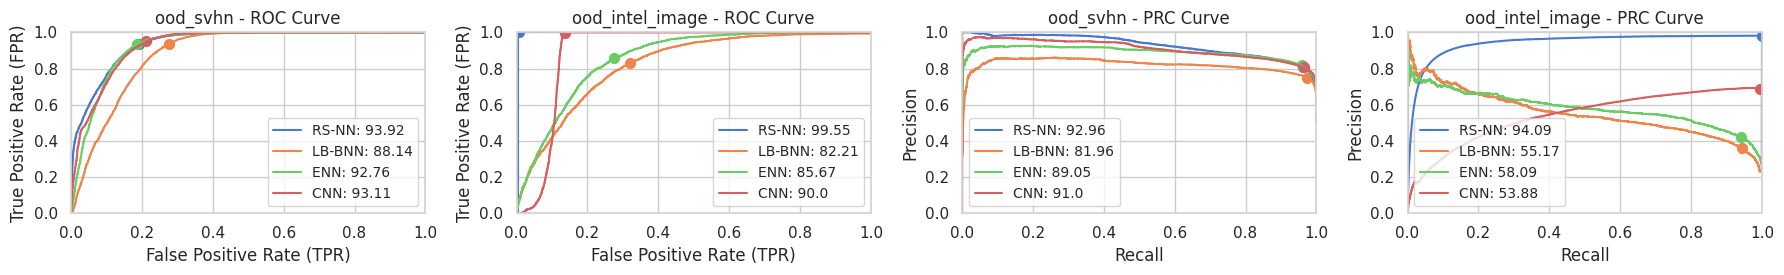

In [15]:
import seaborn as sns
from cycler import cycler

# Set Seaborn style
sns.set(style="white", palette="muted")

muted_colors = sns.color_palette("muted", n_colors=len(models))

# Create subplots with two rows for each dataset
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
legend_locs = ['lower right']*2+['lower left']*2

for j, metric in enumerate(["ROC Curve", "PRC Curve"]):
    for i, dataset in enumerate(ood_dataset_strings):
        name = ood_dataset_names[i]

        ax = axes[(j*2)+i]
        ax.set_title(f'{name} - {metric}')
        ax.set_xlabel('False Positive Rate (TPR)') if metric == "ROC Curve" else ax.set_xlabel('Recall')
        ax.set_ylabel('True Positive Rate (FPR)') if metric == "ROC Curve" else ax.set_ylabel('Precision')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.grid(True)  # Remove the grid

        # Apply milder tones to the line styles
        ax.set_prop_cycle(cycler('color', muted_colors))

        for k, baseline in enumerate(baselines):
            fpr = metrics_data[dataset][baseline]["fpr"]
            tpr = metrics_data[dataset][baseline]["tpr"]
            precision = metrics_data[dataset][baseline]["precision"]
            recall = metrics_data[dataset][baseline]["recall"]
            auroc = metrics_data[dataset][baseline]["AUROC"]*100
            auprc = metrics_data[dataset][baseline]["AUPRC"]*100

            if metric == "ROC Curve":
                ax.plot(fpr, tpr, label=f'{baseline}: {np.round(auroc,2)}')
                auroc_index = np.argmax(tpr - fpr)
                ax.scatter(fpr[auroc_index], tpr[auroc_index], marker='o', s=50)

            else:
                ax.plot(recall, precision, label=f'{baseline}: {np.round(auprc,2)}')
                auprc_index = np.argmax(precision + recall)
                ax.scatter(recall[auprc_index], precision[auprc_index], marker='o', s=50)

        ax.legend(prop={'size': 10}, loc=legend_locs[(j*2)+i])
        ax.margins(x=0)
        for pos in ['right', 'top', 'bottom', 'left']: 
            ax.spines[pos].set_color("lightgray") 

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Confidence scores

In [16]:
ood_dataset_strings_with_iid = [selected_dataset] + ood_dataset_strings
ood_dataset_names_with_iid = [selected_dataset] + ood_dataset_names
confidence_dict = {baseline: {} for baseline in predictions_dict}

for baseline in baselines:
    for ood_dataset_str, ood_dataset_name in zip(ood_dataset_strings_with_iid, ood_dataset_names_with_iid):
        confidence_values = np.max(predictions_dict[baseline][ood_dataset_str], axis = 1)
        confidence_dict[baseline][ood_dataset_str] = confidence_values
        mean_confidence = np.mean(confidence_values)
        std_confidence = np.std(confidence_values)
        
        print(f"Confidence of {baseline} on {ood_dataset_name} = {round(mean_confidence, 4)} +/- {round(std_confidence, 4)}")
    print()

Confidence of RS-NN on cifar10 = 0.9808 +/- 0.0809
Confidence of RS-NN on ood_svhn = 0.712 +/- 0.2673
Confidence of RS-NN on ood_intel_image = 0.4869 +/- 0.0028

Confidence of LB-BNN on cifar10 = 0.951200008392334 +/- 0.1200999990105629
Confidence of LB-BNN on ood_svhn = 0.7817000150680542 +/- 0.18279999494552612
Confidence of LB-BNN on ood_intel_image = 0.8109999895095825 +/- 0.20149999856948853

Confidence of ENN on cifar10 = 0.9671000242233276 +/- 0.09790000319480896
Confidence of ENN on ood_svhn = 0.7493000030517578 +/- 0.1826000064611435
Confidence of ENN on ood_intel_image = 0.8392000198364258 +/- 0.18279999494552612

Confidence of CNN on cifar10 = 0.9692999720573425 +/- 0.09399999678134918
Confidence of CNN on ood_svhn = 0.762499988079071 +/- 0.1932000070810318
Confidence of CNN on ood_intel_image = 0.9107000231742859 +/- 0.0674000009894371



## Uncertainty Estimation - ENTROPY

In [17]:
entropy_dict = {baseline: {} for baseline in predictions_dict}

for baseline in baselines:
    for ood_dataset_str, ood_dataset_name in zip(ood_dataset_strings_with_iid, ood_dataset_names_with_iid):
        entropy_values = entropy(predictions_dict[baseline][ood_dataset_str])
        entropy_dict[baseline][ood_dataset_str] = entropy_values
        mean_entropy = np.mean(entropy_values)
        std_entropy = np.std(entropy_values)
        
        print(f"Entropy of {baseline} on {ood_dataset_name} = {round(mean_entropy, 4)} +/- {round(std_entropy, 4)}")
    print()

Entropy of RS-NN on cifar10 = 0.0802 +/- 0.2974
Entropy of RS-NN on ood_svhn = 1.1335 +/- 0.9608
Entropy of RS-NN on ood_intel_image = 1.8703 +/- 0.0395

Entropy of LB-BNN on cifar10 = 0.19179999828338623 +/- 0.41280001401901245
Entropy of LB-BNN on ood_svhn = 0.8288999795913696 +/- 0.5494999885559082
Entropy of LB-BNN on ood_intel_image = 0.763700008392334 +/- 0.7221999764442444

Entropy of ENN on cifar10 = 0.12680000066757202 +/- 0.3237999975681305
Entropy of ENN on ood_svhn = 0.8877000212669373 +/- 0.51419997215271
Entropy of ENN on ood_intel_image = 0.6004999876022339 +/- 0.5787000060081482

Entropy of CNN on cifar10 = 0.11469999700784683 +/- 0.30480000376701355
Entropy of CNN on ood_svhn = 0.9300000071525574 +/- 0.6107000112533569
Entropy of CNN on ood_intel_image = 0.46389999985694885 +/- 0.19499999284744263



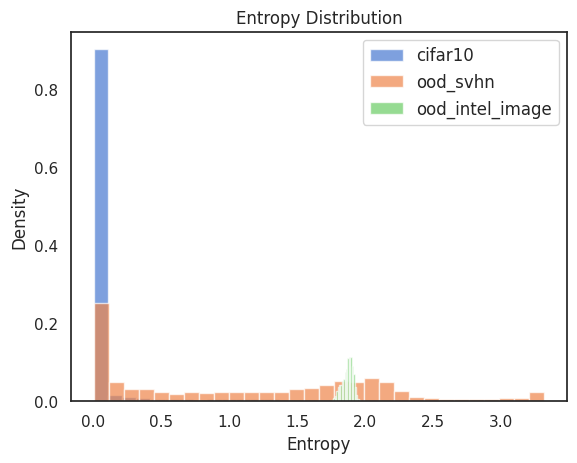

In [18]:
f, ax = plt.subplots(1, 1, sharex=True, facecolor='w', )

bins = 30

ax.hist(entropy(predictions_dict["RS-NN"][selected_dataset]), bins, weights=np.ones(len(predictions_dict["RS-NN"][selected_dataset])) / len(predictions_dict["RS-NN"][selected_dataset]), alpha=0.7, label=f'{selected_dataset}')
ax.hist(entropy(predictions_dict["RS-NN"]["ood_dataset_1"]), bins, weights=np.ones(len(predictions_dict["RS-NN"]["ood_dataset_1"])) / len(predictions_dict["RS-NN"]["ood_dataset_1"]), alpha=0.7, label=f'{ood_dataset_1}')
ax.hist(entropy(predictions_dict["RS-NN"]["ood_dataset_2"]), bins, weights=np.ones(len(predictions_dict["RS-NN"]["ood_dataset_2"])) / len(predictions_dict["RS-NN"]["ood_dataset_2"]), alpha=0.7, label=f'{ood_dataset_2}')

ax.legend(prop={"size": 12})
ax.set_ylabel("Density", fontsize=12)
ax.set_xlabel("Entropy", fontsize=12)
plt.title("Entropy Distribution")
plt.show()


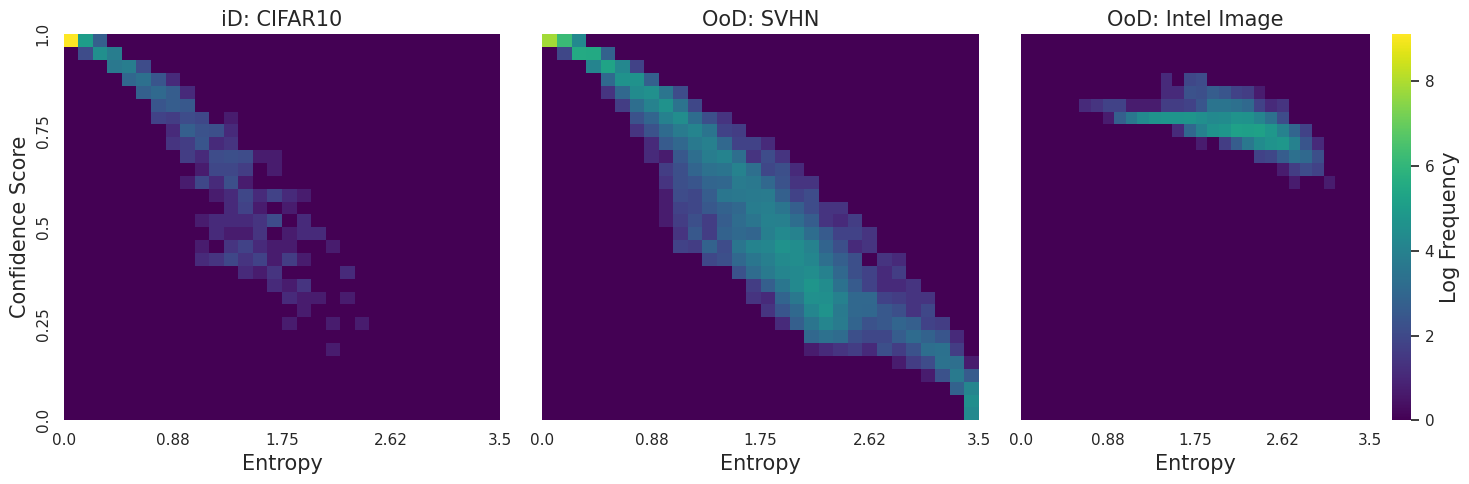

Normalized Heatmaps of Confidence vs. Entropy for different datasets.


In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fontsize = 15

base = np.e
hist_iid = np.emath.logn(base, np.histogram2d(entropy_dict["RS-NN"][selected_dataset], confidence_dict["RS-NN"][selected_dataset], bins=30)[0].T + 1e-31)
hist_svhn = np.emath.logn(base, np.histogram2d(entropy_dict["RS-NN"]["ood_dataset_1"], confidence_dict["RS-NN"]["ood_dataset_1"], bins=30)[0].T + 1e-31)
hist_intel = np.emath.logn(base, np.histogram2d(entropy_dict["RS-NN"]["ood_dataset_2"], confidence_dict["RS-NN"]["ood_dataset_2"], bins=30)[0].T + 1e-31)

col_name = "viridis"
color_palette = sns.color_palette(col_name, as_cmap=True)

sns.heatmap(data=hist_iid, cmap=color_palette, cbar=False, ax=axes[0], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_svhn, cmap=color_palette, cbar=False, ax=axes[1], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_intel, cmap=color_palette, cbar=True, ax=axes[2], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))

axes[0].set_title("iD: CIFAR10", fontsize=fontsize)
axes[1].set_title("OoD: SVHN", fontsize=fontsize)
axes[2].set_title("OoD: Intel Image", fontsize=fontsize)

for ax in axes:
    try:
        ax.collections[0].colorbar.set_label('Log Frequency', fontsize=fontsize)
    except:
        pass

for i, ax in enumerate(axes):
    ax.set_xticks(np.linspace(0, 30, 5))
    ax.set_xticklabels(np.round(np.linspace(0, 3.5, 5), 2), rotation=0)

axes[0].set_yticks(np.linspace(0, 30, 5))
axes[0].set_yticklabels(np.round(np.linspace(0, 1, 5), 2))

for i, ax in enumerate(axes):
    ax.set_xlabel("Entropy", fontsize=fontsize)
    ax.invert_yaxis()

axes[0].set_ylabel("Confidence Score", fontsize=fontsize)

plt.tight_layout()
plt.show()

print("Normalized Heatmaps of Confidence vs. Entropy for different datasets.")

## Uncertainty Estimation - CREDAL SET WIDTH

In [20]:
# Mass functions to compute credal set vertices  
test_preds_mass_1 = test_preds_masses[ood_dataset_1]
test_preds_mass_2 = test_preds_masses[ood_dataset_2]

rsnn_dict = {
    selected_dataset: {"final_bet_p": final_bet_p, "test_preds_mass": test_preds_mass},
    "ood_dataset_1": {"final_bet_p": final_bet_p_1, "test_preds_mass": test_preds_mass_1},
    "ood_dataset_2": {"final_bet_p": final_bet_p_2, "test_preds_mass": test_preds_mass_2}
}

vertices_list_dict = {}

# Loop through each dataset
for dataset_name, values in rsnn_dict.items():
    final_bet_p_dataset = values["final_bet_p"]
    test_preds_mass_dataset = values["test_preds_mass"]
    vertices_list = []
    for k in range(len(final_bet_p_dataset)):
        vertices_list.append(compute_vertices(test_preds_mass_dataset[k], classes, np.argmax(final_bet_p, axis = -1)[k], new_classes_with_full))
    
    # Save vertices_list for the current dataset
    vertices_list_dict[dataset_name] = np.array(vertices_list)

In [21]:
credal_set_width_dict = {dataset_name: {} for dataset_name in vertices_list_dict}

# Loop through each dataset
for dataset_name, vertices_list in vertices_list_dict.items():
    credal_set_width_values = np.max(vertices_list, axis=1) - np.min(vertices_list, axis=1)
    credal_set_width_dict[dataset_name] = credal_set_width_values
    mean_width = np.mean(credal_set_width_values)
    std_width = np.std(credal_set_width_values)
    
    print(f"Credal set width for {dataset_name} : {mean_width} +/- {std_width}")

Credal set width for cifar10 : 0.006138458783406057 +/- 0.03966967339103113
Credal set width for ood_dataset_1 : 0.11662358092011066 +/- 0.22835114914314225
Credal set width for ood_dataset_2 : 0.21151614510850475 +/- 0.3123076999449519


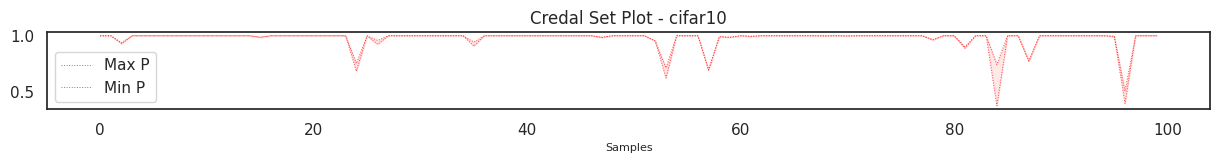

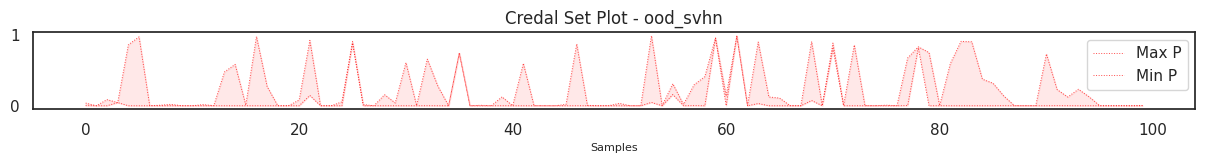

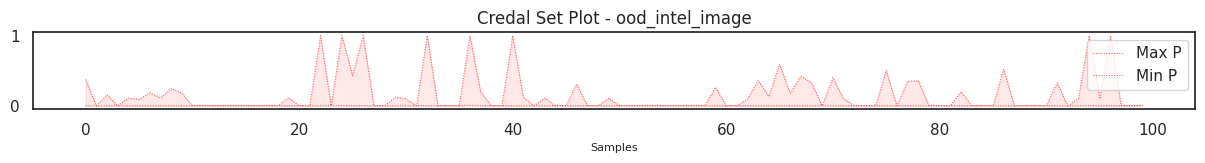

In [22]:
vertices_lists = [vertices_list_dict[dataset] for dataset in ood_dataset_strings_with_iid]

# Loop through each dataset
for idx, (dataset_name, vertices_list) in enumerate(zip(ood_dataset_strings_with_iid, vertices_lists)):
    # Create subplots for each dataset
    fig, ax = plt.subplots(figsize=(15, 1)) 
    font = {'family': 'sans-serif', 'weight': 'normal', 'size': 8}
    plt.rc('font', **font)

    # Plot the max and min P values
    ax.plot(np.max(vertices_list[:100], axis=-1), color='red', label='Max P', linewidth=0.7, linestyle="dotted", alpha=0.7)
    ax.plot(np.min(vertices_list[:100], axis=-1), color='red', label='Min P', linewidth=0.7, linestyle="dotted", alpha=0.7)

    # Fill the area between max and min P
    ax.fill_between(np.arange(100), np.max(vertices_list[:100], axis=-1), np.min(vertices_list[:100], axis=-1), color='red', alpha=.09)
    
    plt.xlabel('Samples', fontdict=font)
    plt.legend()

    # Show the plot
    plt.title(f"Credal Set Plot - {ood_dataset_names_with_iid[idx]}")
    plt.show()

/tmp/ipykernel_4155798/287698906.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridisBig2 = cm.get_cmap('Oranges_r', 512)
/tmp/ipykernel_4155798/287698906.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridisBig = cm.get_cmap('viridis', 512)
/tmp/ipykernel_4155798/287698906.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_incorrect = plt.cm.get_cmap(newcmp2)
/tmp/ipykernel_4155798/287698906.py:36: MatplotlibDeprecationWarning: The get_cmap function was de

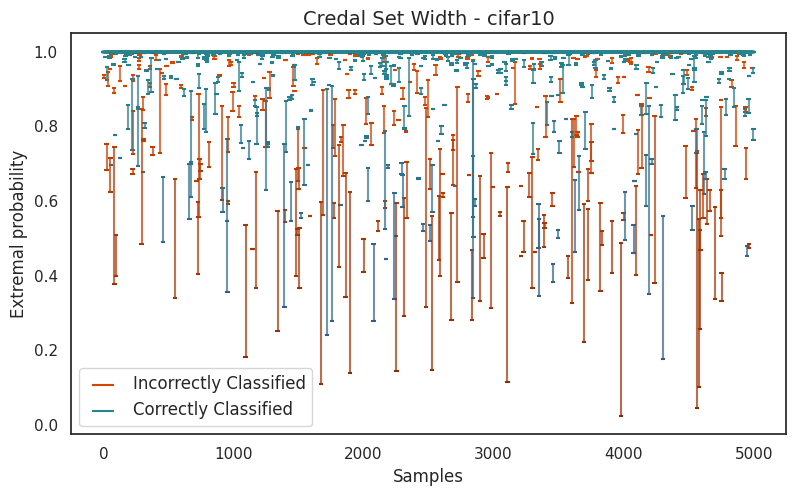

In [23]:
viridisBig2 = cm.get_cmap('Oranges_r', 512)
newcmp2 = ListedColormap(viridisBig2(np.linspace(0, 0.25, 256)))
viridisBig = cm.get_cmap('viridis', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.20, 0.45, 256)))

num_samples_to_disp = 5000

# Create the figure and axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

for idx, (dataset_key, vertices_list) in enumerate(zip(ood_dataset_strings_with_iid, vertices_lists)):
    # Extract data for the current dataset
    dataset_data = rsnn_dict[dataset_key]
    final_bet_p_dataset = dataset_data["final_bet_p"]

    # Skip datasets other than CIFAR-10
    if dataset_key != selected_dataset:
        continue

    # Create correct and incorrect indices for the current dataset
    correct_idx, incorrect_idx = compute_correct_incorrect_indices(final_bet_p_dataset, y_test)

    subset_incorrect_indices = incorrect_idx[incorrect_idx < num_samples_to_disp]
    subset_incorrect = vertices_list[subset_incorrect_indices]

    max_values_incorrect = np.max(subset_incorrect, axis=1)
    min_values_incorrect = np.min(subset_incorrect, axis=1)

    x_incorrect = np.arange(len(vertices_list))[subset_incorrect_indices]

    for i in range(len(subset_incorrect)):
        cmap_incorrect = plt.cm.get_cmap(newcmp2)
        color_incorrect = cmap_incorrect((max_values_incorrect[i] + min_values_incorrect[i]) / 2)
        ax.vlines(x_incorrect[i], ymin=min_values_incorrect[i], ymax=max_values_incorrect[i], color=color_incorrect, alpha=0.7)

    cmap_incorrect = plt.cm.get_cmap(newcmp2)
    max_colors_incorrect = cmap_incorrect(max_values_incorrect)
    min_colors_incorrect = cmap_incorrect(min_values_incorrect)
    ax.scatter(x_incorrect, max_values_incorrect, marker='_', s=10, c=max_colors_incorrect, label='Incorrectly Classified')
    ax.scatter(x_incorrect, min_values_incorrect, marker='_', s=10, c=min_colors_incorrect)
    
    subset_correct_indices = correct_idx[correct_idx < num_samples_to_disp]
    subset_correct = vertices_list[subset_correct_indices]

    max_values_correct = np.max(subset_correct, axis=1)
    min_values_correct = np.min(subset_correct, axis=1)

    x_correct = np.arange(len(vertices_list))[subset_correct_indices]

    for i in range(len(subset_correct)):
        cmap_correct = plt.cm.get_cmap(newcmp)
        color_correct = cmap_correct((max_values_correct[i] + min_values_correct[i]) / 2)
        ax.vlines(x_correct[i], ymin=min_values_correct[i], ymax=max_values_correct[i], color=color_correct, alpha=0.7)

    cmap_correct = plt.cm.get_cmap(newcmp)
    max_colors_correct = cmap_correct(max_values_correct)
    min_colors_correct = cmap_correct(min_values_correct)
    ax.scatter(x_correct, max_values_correct, marker='_', s=10, c=max_colors_correct, label='Correctly Classified')
    ax.scatter(x_correct, min_values_correct, marker='_', s=10, c=min_colors_correct)

    ax.set_xlabel('Samples', fontsize=12)
    ax.set_ylabel('Extremal probability', fontsize=12)
    ax.set_title(f'Credal Set Width - {ood_dataset_names_with_iid[idx]}', fontsize=14)

    ax.legend(prop={"size": 12}, markerscale=5.0)

plt.tight_layout()
plt.show()

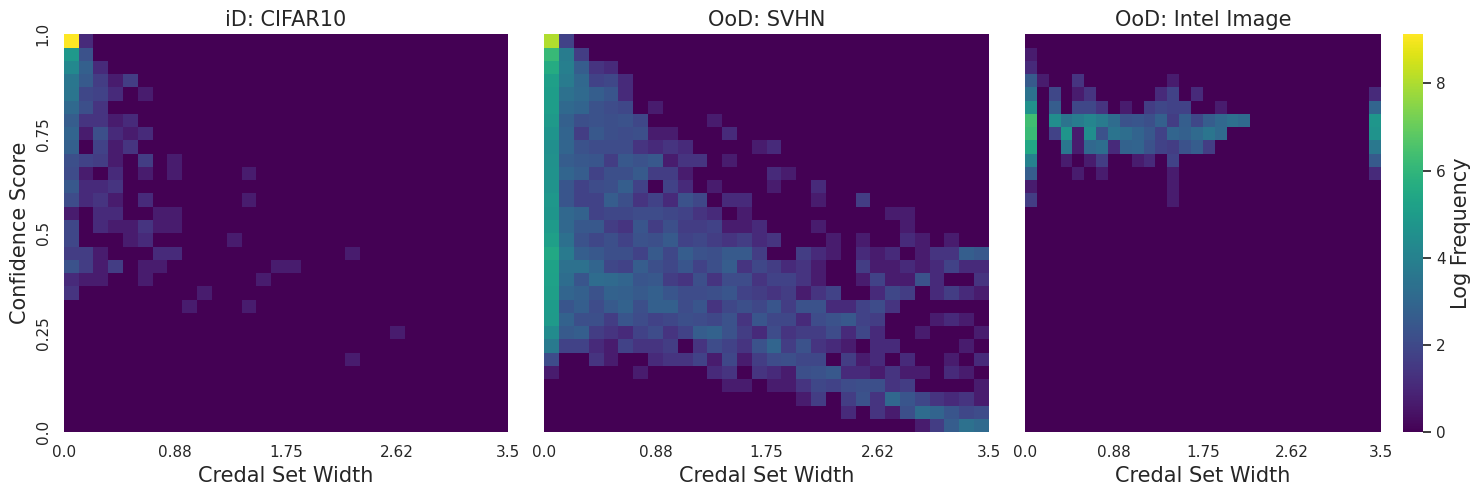

Normalized Heatmaps of Confidence vs. Credal Set Width for different datasets.


In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fontsize = 15

base = np.e
hist_iid = np.emath.logn(base, np.histogram2d(credal_set_width_dict[selected_dataset], confidence_dict["RS-NN"][selected_dataset], bins=30)[0].T + 1e-31)
hist_svhn = np.emath.logn(base, np.histogram2d(credal_set_width_dict["ood_dataset_1"], confidence_dict["RS-NN"]["ood_dataset_1"], bins=30)[0].T + 1e-31)
hist_intel = np.emath.logn(base, np.histogram2d(credal_set_width_dict["ood_dataset_2"], confidence_dict["RS-NN"]["ood_dataset_2"], bins=30)[0].T + 1e-31)

col_name = "viridis"
color_palette = sns.color_palette(col_name, as_cmap=True)

sns.heatmap(data=hist_iid, cmap=color_palette, cbar=False, ax=axes[0], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_svhn, cmap=color_palette, cbar=False, ax=axes[1], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_intel, cmap=color_palette, cbar=True, ax=axes[2], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))

axes[0].set_title("iD: CIFAR10", fontsize=fontsize)
axes[1].set_title("OoD: SVHN", fontsize=fontsize)
axes[2].set_title("OoD: Intel Image", fontsize=fontsize)

for ax in axes:
    try:
        ax.collections[0].colorbar.set_label('Log Frequency', fontsize=fontsize)
    except:
        pass

for i, ax in enumerate(axes):
    ax.set_xticks(np.linspace(0, 30, 5))
    ax.set_xticklabels(np.round(np.linspace(0, 3.5, 5), 2), rotation=0)

axes[0].set_yticks(np.linspace(0, 30, 5))
axes[0].set_yticklabels(np.round(np.linspace(0, 1, 5), 2))

for i, ax in enumerate(axes):
    ax.set_xlabel("Credal Set Width", fontsize=fontsize)
    ax.invert_yaxis()

axes[0].set_ylabel("Confidence Score", fontsize=fontsize)

plt.tight_layout()
plt.show()

print("Normalized Heatmaps of Confidence vs. Credal Set Width for different datasets.")

## Adversarial samples - NOISY

In [25]:
# Change scales to test the model's robustness
x_test_noisy = add_random_noise(x_test, scale = 0.4)
x_test_org_noisy = add_random_noise(x_test_org, scale = 0.4)

# Get predictions and calculate accuracy of RS-NN
test_preds_noisy = new_model.predict(x_test_noisy, verbose=1)
test_preds_mass_noisy = belief_to_mass(test_preds_noisy, list(new_classes))
final_bet_p_noisy = final_betp(test_preds_mass_noisy, classes, new_classes_with_full)
final_bet_p_indices_noisy = np.argmax(final_bet_p_noisy, axis = -1)
accuracy_noisy = (np.sum(final_bet_p_indices_noisy == y_test)/len(y_test))*100
print(f"Test Accuracy of RS-NN on Noisy test images using pignistic probability: {accuracy_noisy}%")

# Get predictions and calculate accuracy of CNN
y_pred_noisy = model.predict(x_test_noisy)
score_noisy = model.evaluate(x_test_noisy, y_test_one_hot)
print(f"Test Accuracy of standard CNN on Noisy test images: {score_noisy[1]*100}%")

313/313 [==============================] - 5s 16ms/step
Test Accuracy of RS-NN on Noisy test images using pignistic probability: 39.28%
313/313 [==============================] - 5s 17ms/step - loss: 5.1351 - accuracy: 0.3046
Test Accuracy of standard CNN on Noisy test images: 30.460000038146973%


## Adversarial samples - ROTATED

In [26]:
# Change rotation angles to test the model's robustness
x_test_rotated = rotate_images(x_test, start_angle = -30, end_angle= 90)
x_test_org_rotated = rotate_images(x_test_org, start_angle = -30, end_angle= 90)

# Get predictions and calculate accuracy of RS-NN
test_preds_rotated = new_model.predict(x_test_rotated, verbose=1)
test_preds_mass_rotated = belief_to_mass(test_preds_rotated, list(new_classes))
final_bet_p_rotated = final_betp(test_preds_mass_rotated, classes, new_classes_with_full)
final_bet_p_indices_rotated = np.argmax(final_bet_p_rotated, axis = -1)
accuracy_rotated = (np.sum(final_bet_p_indices_rotated == y_test)/len(y_test))*100
print(f"Test Accuracy of RS-NN on Rotated test images using pignistic probability: {accuracy_rotated}%")

# Get predictions and calculate accuracy of CNN
y_pred_rotated = model.predict(x_test_rotated)
score_rotated = model.evaluate(x_test_rotated, y_test_one_hot)
print(f"Test Accuracy of standard CNN on Rotated test images : {score_rotated[1]*100}%")

313/313 [==============================] - 5s 16ms/step
Test Accuracy of RS-NN on Rotated test images using pignistic probability: 60.540000000000006%
313/313 [==============================] - 5s 17ms/step - loss: 2.7694 - accuracy: 0.5673
Test Accuracy of standard CNN on Rotated test images : 56.7300021648407%
